In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy import linalg as LA

In [7]:
book_params = False
openMC_xs = False
analytical_xs = False


x_a = 0.0
x_interface = 3.44
x_b = 10.0

fdp_full = True

if book_params:
    diff_coeff_u1_c = 1.0
    diff_coeff_u1_m = 1.0

    fiss_u1_c = 0.057
    #fiss_u1_c = 30

    sigma_abs_u1_c = 0.001
    sigma_abs_u1_m = 0.001
    
else:

    diff_coeff_u1_c = 1.84
    diff_coeff_u1_m = 1.64

    fiss_u1_c = 0.174
    #fiss_u1_c = 30

    sigma_abs_u1_c = 0.0745
    sigma_abs_u1_m = 0.00534
    
if openMC_xs:
    diff_coeff_u1_c = 1.33

    diff_coeff_u1_m = 7.25e-01

    sigma_s12_c = 3.21e-07
    sigma_s12_m = 3.74e-04

    fiss_u1_c = 2.20e-01

    sigma_abs_u1_c = 7.61e-02
    sigma_abs_u2_c = 1.10e+01

    sigma_abs_u1_m = 1.47e-03
    sigma_abs_u2_m = 5.94e-04

if analytical_xs:
    v=3.1
    diff_coeff_u1_c=1.83180150273944
    diff_coeff_u1_m = 1.64
    
    fiss_u1_c=0.07713955230125523 * v
    
    sigma_abs_u1_c=0.003955874476987448
    sigma_abs_u1_m = 0.00534
    
    sigma_12_c=0.03560287029288703
    

order = variable_order = 'second'
flux_order = 'first'

diffFlux_family = 'monomial_vec'
diffFlux_r_family = 'monomial'

#robin_u_ref = 0.0
#robin_transfer_coeff = 10.0e+10

n_felem_core = 300
n_felem_reflector = 300

u1_initial = 100000

interfacial_transfer_coeff = 1000000000000000000.0
interfacial_adsorption_coeff = 0

u1_bc_left_neumann = 0
u2_bc_left_neumann = 0

u1_bc_right_robin_transfer_coeff = 10.0e+10

n_plot_pts_core = 2*n_felem_core + 1
n_plot_pts_reflector = 2*n_felem_reflector + 1

flux_ref = 0.0   #u_ref for robin boundary condition

inputFileName = "input_2Domain.hit"

In [8]:
def write_input_file_1d_coupled(pjfnk=False,filename='input.hit'):
    import pyhit
    import moosetree
    root = pyhit.load('')

    prblm = root.insert(-1,'Problem')
    prblm['type'] = 'FEProblem'
    prblm['coord_type'] = 'RSPHERICAL'

    mesh = root.insert(-1,'Mesh')
    
    omega1 = mesh.insert(-1,'omega1')
    omega1['type'] = 'GeneratedMeshGenerator'
    omega1['dim'] = 1
    omega1['xmin'] = x_a
    omega1['xmax'] = x_interface
    omega1['nx'] = n_felem_core
    omega1['boundary_name_prefix'] = 'omega_1'
    if order == 'second':
        omega1['elem_type'] = 'edge3'
    
    omega2 = mesh.insert(-1,'omega2')
    omega2['type'] = 'GeneratedMeshGenerator'
    omega2['dim'] = 1
    omega2['xmin'] = x_interface
    omega2['xmax'] = x_b
    omega2['nx'] = n_felem_reflector
    omega2['boundary_name_prefix'] = 'omega_2'
    if order == 'second':
        omega2['elem_type'] = 'edge3'

    omega = mesh.insert(-1,'omega')
    omega['type'] = 'StitchedMeshGenerator'
    omega['inputs'] = "'omega1 omega2'"
    omega['stitch_boundaries_pairs'] = "'omega_1_right omega_2_left'"
    omega['clear_stitched_boundary_ids'] = 'true'
    
    mod1 = mesh.insert(-1,'mod1')
    mod1['type'] = 'SubdomainBoundingBoxGenerator'
    mod1['input'] = 'omega'
    mod1['block_id'] = 1
    mod1['block_name'] = 'omega_1'
    mod1['bottom_left'] = str(x_a)+' 0 0'
    mod1['top_right'] = str(x_interface)+' 1 0'
    
    mod2 = mesh.insert(-1,'mod2')
    mod2['type'] = 'SubdomainBoundingBoxGenerator'
    mod2['input'] = 'mod1'
    mod2['block_id'] = 2
    mod2['block_name'] = 'omega_2'
    mod2['bottom_left'] = str(x_interface)+' 0 0'
    mod2['top_right'] = str(x_b)+' 1 0'
    
    mod3 = mesh.insert(-1,'mod3')
    mod3['type'] = 'SideSetsBetweenSubdomainsGenerator'
    mod3['input'] = 'mod2'
    mod3['primary_block'] = 'omega_1'
    mod3['paired_block'] = 'omega_2' 
    mod3['new_boundary'] = 'interface_12'
    
    mod4 = mesh.insert(-1,'mod4')
    mod4['type'] = 'SideSetsAroundSubdomainGenerator'
    mod4['input'] = 'mod3'
    mod4['block'] = 'omega_1'
    mod4['normal'] = '-1 0 0'
    mod4['new_boundary'] = 'omega_1_left'
    
    mod5 = mesh.insert(-1,'mod5')
    mod5['type'] = 'SideSetsAroundSubdomainGenerator'
    mod5['input'] = 'mod4'
    mod5['block'] = 'omega_2'
    mod5['normal'] = '1 0 0'
    mod5['new_boundary'] = 'omega_2_right'
    
    vars = root.insert(-1,'Variables')
    
    u1_c = vars.insert(-1,'u1_c')
    u1_c['block'] = 'omega_1'
    u1_c['order'] = order
    u1_c['family'] = 'lagrange'
    u1_c['initial_condition'] = u1_initial
    
    u1_m = vars.insert(-1,'u1_m')
    u1_m['block'] = 'omega_2'
    u1_m['order'] = order
    u1_m['family'] = 'lagrange'
    u1_m['initial_condition'] = u1_initial
    
    aux_vars = root.insert(-1,'AuxVariables')
    
    diffFlux_u1_c = aux_vars.insert(-1,'diffFlux_u1_c')
    diffFlux_u1_c['block'] = 'omega_1'
    diffFlux_u1_c['order'] = flux_order
    diffFlux_u1_c['family'] = diffFlux_family

    diffFlux_u1_m = aux_vars.insert(-1,'diffFlux_u1_m')
    diffFlux_u1_m['block'] = 'omega_2'
    diffFlux_u1_m['order'] = flux_order
    diffFlux_u1_m['family'] = diffFlux_family
    
    diffFlux_u1_c_r = aux_vars.insert(-1,'diffFlux_u1_c_r')
    diffFlux_u1_c_r['block'] = 'omega_1'
    diffFlux_u1_c_r['order'] = flux_order
    diffFlux_u1_c_r['family'] = diffFlux_r_family

    diffFlux_u1_m_r = aux_vars.insert(-1,'diffFlux_u1_m_r')
    diffFlux_u1_m_r['block'] = 'omega_2'
    diffFlux_u1_m_r['order'] = flux_order
    diffFlux_u1_m_r['family'] = diffFlux_r_family

    kernels = root.insert(-1,'Kernels')
    
    diffusion_term_u1_c = kernels.insert(-1,'diffusion_term_u1_c')
    diffusion_term_u1_c['type'] = 'DiffusionTerm'
    diffusion_term_u1_c['block'] = 'omega_1'
    diffusion_term_u1_c['variable'] = 'u1_c'
    diffusion_term_u1_c['diffCoeff'] = diff_coeff_u1_c
    
    diffusion_term_u1_m = kernels.insert(-1,'diffusion_term_u1_m')
    diffusion_term_u1_m['type'] = 'DiffusionTerm'
    diffusion_term_u1_m['block'] = 'omega_2'
    diffusion_term_u1_m['variable'] = 'u1_m'
    diffusion_term_u1_m['diffCoeff'] = diff_coeff_u1_m
    
    fission_source_u1_c = kernels.insert(-1,'fission_source_u1_c')
    fission_source_u1_c['type'] = 'FissionSource'
    fission_source_u1_c['block'] = 'omega_1'
    fission_source_u1_c['variable'] = 'u1_c'
    fission_source_u1_c['Sigma_nu'] = fiss_u1_c
    
    abs_u1_c = kernels.insert(-1,'abs_u1_c')
    abs_u1_c['type'] = 'SourceTermG1'
    abs_u1_c['block'] = 'omega_1'
    abs_u1_c['variable'] = 'u1_c'
    abs_u1_c['sigma_sa'] = -sigma_abs_u1_c
    
    abs_u1_m = kernels.insert(-1,'abs_u1_m')
    abs_u1_m['type'] = 'SourceTermG1'
    abs_u1_m['block'] = 'omega_2'
    abs_u1_m['variable'] = 'u1_m'
    abs_u1_m['sigma_sa'] = -sigma_abs_u1_m
    
    interf_kernels = root.insert(-1,'InterfaceKernels')
    
    scalar_flux_continuity_u1 = interf_kernels.insert(-1,'scalar_flux_continuity_u1')
    scalar_flux_continuity_u1['type'] = 'InterfaceDiffusion'
    scalar_flux_continuity_u1['variable'] = 'u1_c'
    scalar_flux_continuity_u1['neighbor_var'] = 'u1_m'
    scalar_flux_continuity_u1['boundary'] = 'interface_12'
    scalar_flux_continuity_u1['D'] = diff_coeff_u1_c
    scalar_flux_continuity_u1['D_neighbor'] = diff_coeff_u1_m
    
    scalar_flux_jump_u1 = interf_kernels.insert(-1,'scalar_flux_jump_u1')
    scalar_flux_jump_u1['type'] = 'InterfacePartition'
    scalar_flux_jump_u1['variable'] = 'u1_c'
    scalar_flux_jump_u1['neighbor_var'] = 'u1_m'
    scalar_flux_jump_u1['boundary'] = 'interface_12'
    scalar_flux_jump_u1['kCoeff'] = 1
    
    aux_kernels = root.insert(-1,'AuxKernels')
    
    diffusion_flux_u1_c = aux_kernels.insert(-1,'diffusion_flux_u1_c')
    diffusion_flux_u1_c['type'] = 'HeatFlux'
    diffusion_flux_u1_c['block'] = 'omega_1'
    diffusion_flux_u1_c['field'] = 'u1_c'
    diffusion_flux_u1_c['thCondCoeff'] = diff_coeff_u1_c
    diffusion_flux_u1_c['variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c['execute_on'] = 'timestep_end'
    
    diffusion_flux_u1_m = aux_kernels.insert(-1,'diffusion_flux_u1_m')
    diffusion_flux_u1_m['type'] = 'HeatFlux'
    diffusion_flux_u1_m['block'] = 'omega_2'
    diffusion_flux_u1_m['field'] = 'u1_m'
    diffusion_flux_u1_m['thCondCoeff'] = diff_coeff_u1_m
    diffusion_flux_u1_m['variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m['execute_on'] = 'timestep_end'
  
    diffusion_flux_u1_c_r = aux_kernels.insert(-1,'diffusion_flux_u1_c_r')
    diffusion_flux_u1_c_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u1_c_r['block'] = 'omega_1'
    diffusion_flux_u1_c_r['vector_variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c_r['component'] = "x"
    diffusion_flux_u1_c_r['variable'] = 'diffFlux_u1_c_r'
    diffusion_flux_u1_c_r['execute_on'] = 'timestep_end'

    diffusion_flux_u1_m_r = aux_kernels.insert(-1,'diffusion_flux_u1_m_r')
    diffusion_flux_u1_m_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u1_m_r['block'] = 'omega_2'
    diffusion_flux_u1_m_r['vector_variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m_r['component'] = "x"
    diffusion_flux_u1_m_r['variable'] = 'diffFlux_u1_m_r'
    diffusion_flux_u1_m_r['execute_on'] = 'timestep_end'
    
    
    bcs = root.insert(-1,'BCs')
    
    entry_u1 = bcs.insert(-1,'entry_u1')
    entry_u1['type'] = 'NeumannBC'
    entry_u1['variable'] = 'u1_c'
    entry_u1['boundary'] = 'omega_1_left'
    entry_u1['value'] = u1_bc_left_neumann 
    
    exit_u1 = bcs.insert(-1,'exit_u1')
    exit_u1['type'] = 'VacuumBC'
    exit_u1['variable'] = 'u1_m'
    exit_u1['boundary'] = 'omega_2_right'
    
    functions = root.insert(-1,'Functions')
    
    ref_flux_func = functions.insert(-1, 'refFluxFunc')
    ref_flux_func['type'] = 'ParsedFunction'
    ref_flux_func['value'] = 'flux_ref'
    ref_flux_func['vars'] = 'flux_ref'
    ref_flux_func['vals'] = str(flux_ref)
    
    if pjfnk:
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'
        exe['solve_type']  = 'PJFNK'
        exe['petsc_options_iname']  = '-pc_type -pc_hypre_type'
        exe['petsc_options_value']  = 'hypre boomeramg'
        exe['l_max_its']  = 20
        exe['l_tol']  = 1e-5
        exe['nl_max_its']  = 15
        exe['nl_rel_tol']  = 1e-8
        exe['nl_abs_tol']  = 1e-8
    elif fdp_full:
        pre = root.insert(-1, 'Preconditioning')
        pre['active'] = 'fdp-newt-full'
        
        fdp = pre.insert(-1, 'fdp-newt-full')
        fdp['type'] = 'FDP'
        fdp['full'] = 'true'
        fdp['solve_type'] = 'NEWTON'
        fdp['petsc_options_iname'] = ""'-pc_type -mat_fd_coloring_err -mat_fd_type'""
        fdp['petsc_options_value'] = ""'lu  1e-8          ds'""
        
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'

    vp = root.insert(-1,'VectorPostprocessors')
    
    omega_1 = vp.insert(-1,'omega_1')
    omega_1['type'] = 'LineValueSampler'
    omega_1['execute_on'] = 'timestep_end final'
    omega_1['variable'] = 'u1_c diffFlux_u1_c_r'  
    omega_1['start_point'] = str(x_a)+' 0 0'
    omega_1['end_point'] = str(x_interface*0.999)+' 0 0'
    omega_1['num_points'] = n_plot_pts_core
    omega_1['sort_by'] = 'id'
    
    omega_2 = vp.insert(-1,'omega_2')
    omega_2['type'] = 'LineValueSampler'
    omega_2['execute_on'] = 'timestep_end final'
    omega_2['variable'] = 'u1_m diffFlux_u1_m_r'   
    omega_2['start_point'] = str(x_interface*1.001)+' 0 0'
    omega_2['end_point'] = str(x_b)+' 0 0'
    omega_2['num_points'] = n_plot_pts_reflector
    omega_2['sort_by'] = 'id'  

    out = root.insert(-1,'Outputs')
    out['console'] = 'true'
    csv = out.insert(-1,'csv')
    csv['type'] = 'CSV'
    csv['file_base'] = 'output'
    csv['execute_on'] = 'final'
    
    debug = root.insert(-1,'Debug')
    debug['show_var_residual_norms'] = 'true'

    pyhit.write(filename, root)

In [9]:
write_input_file_1d_coupled(pjfnk=True,filename=inputFileName)
!cat input_2Domain.hit

[Problem]
  type = FEProblem
  coord_type = RSPHERICAL
[]
[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 0.0
    xmax = 3.44
    nx = 300
    boundary_name_prefix = omega_1
    elem_type = edge3
  []
  [omega2]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 3.44
    xmax = 10.0
    nx = 300
    boundary_name_prefix = omega_2
    elem_type = edge3
  []
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'omega_1_right omega_2_left'
    clear_stitched_boundary_ids = true
  []
  [mod1]
    type = SubdomainBoundingBoxGenerator
    input = omega
    block_id = 1
    block_name = omega_1
    bottom_left = '0.0 0 0'
    top_right = '3.44 1 0'
  []
  [mod2]
    type = SubdomainBoundingBoxGenerator
    input = mod1
    block_id = 2
    block_name = omega_2
    bottom_left = '3.44 0 0'
    top_right = '10.0 1 0'
  []
  [mod3]
    type = SideSetsBetweenSubdomainsGenerator
    input = mod2
    primary_block = o

In [10]:
!./neutron__transport-opt -i input_2Domain.hit


In ReplicatedMesh::stitch_meshes:
This mesh has 1 nodes on boundary 1.
Other mesh has 1 nodes on boundary 0.
Minimum edge length on both surfaces is 0.0114667.
In ReplicatedMesh::stitch_meshes:
Found 1 matching nodes.

Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  9 07:46:33 2022
Executable Timestamp:    Mon May  9 00:12:13 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   1201
  Elems:                   600
  Num Subdomains:          2

Nonlinear System:
  Num DOFs:                1202
  Num Local DOFs:          1202
  Variables:               "u1_c" "u1_m" 
  Finite Element Types:    "LAGRANGE" "LAGRANGE" 
  Approximation Orders:    "SECOND" "SECOND" 

Auxiliary System

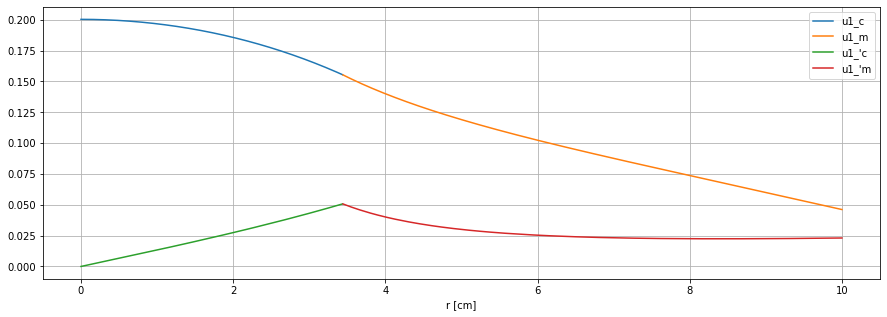

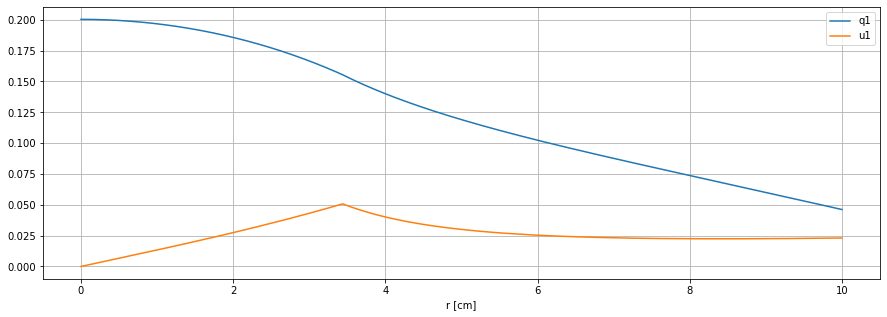

In [11]:
'''Show FEM Solution'''

import pandas as pd
df1 = pd.read_csv('output_omega_1_0002.csv')
df2 = pd.read_csv('output_omega_2_0002.csv')
df_list = [df1,df2]
save_name = "2Domain.png"

#display(df1)
#display(df2)

x_list = [df1["x"],df2["x"]]
y_list = [[df1["diffFlux_u1_c_r"],df1["u1_c"]],
          [df2["diffFlux_u1_m_r"],df2["u1_m"]]]
labels = ["u1'","u1"]
domain = ["core","reflector"]


plt.figure(figsize=(15,5))
for i in range(1):
    for j,domain in enumerate(["c","m"]):
        field = "u"+str(i+1)+"_"
        plt.plot(df_list[j]["x"],df_list[j][field+domain],label=field+domain)
        
    for j,domain in enumerate(["c","m"]):
        field = "u"+str(i+1)+"_"
        plt.plot(df_list[j]["x"],df_list[j]["diffFlux_u"+str(i+1)+"_"+domain+"_r"],label=field+"'"+domain)
        
plt.legend()
plt.grid()
plt.xlabel("r [cm]")
plt.show()


x_total = pd.concat([df1["x"], df2["x"]])
u1 = pd.concat([df1["u1_c"] ,df2["u1_m"]])
u1_prime = pd.concat([df1["diffFlux_u1_c_r"] , df2["diffFlux_u1_m_r"]])

data_list = [u1,u1_prime]
labels = ["q1","u1"]

plt.figure(figsize=(15,5))
for i,data in enumerate(data_list):
    plt.plot(x_total,data,label=labels[i])

plt.legend()
plt.grid()
plt.xlabel("r [cm]")
plt.savefig("1Group.png",dpi=300)
plt.show()

k: 0.7221023184034213


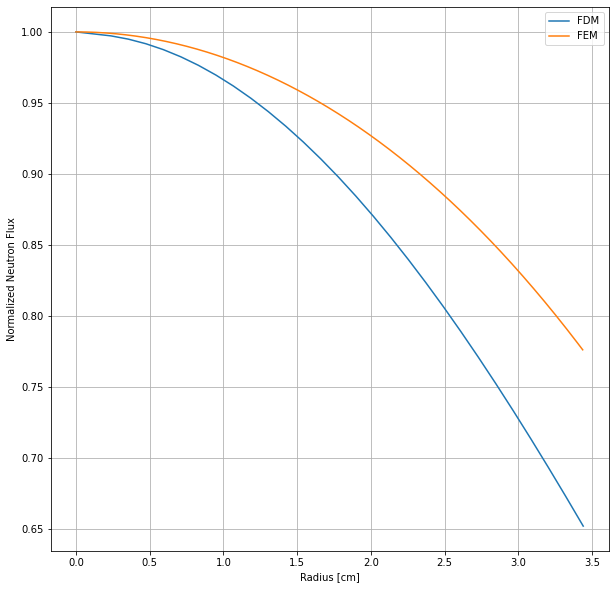

In [12]:
Nr= 30
rn=x_interface 
R=rn
r0=0

D=1.83180150273944
sigma_f=0.07713955230125523
sigma_a=0.003955874476987448
sigma_12=0.03560287029288703
v=3.1
h=(rn-r0)/(Nr-1)
r = np.arange(r0,rn + h,h)
chi=0.575
A=np.zeros((Nr,Nr))
B=np.zeros(Nr)


A[0,0]=-2*D/h**2
A[0,1]=2*D/h**2


for i in range(1,Nr-1):
    A[i,i-1]=(1-(h/r[i]))*D/h**2  
    A[i,i]=-2*D/h**2
    A[i,i+1]=(1+(h/r[i]))*D/h**2


A[-1,-1]=(-2*D/h**2-1/h-1/(rn))
A[-1,-2]=(2)*D/h**2

D, V = LA.eig(A)

eigen_value=D
eigen_vec=V[:,1]
c_star_vec=eigen_vec/LA.norm(eigen_vec[:][0])


eigen_values = np.flip(np.sort(abs(D)))

k=(v*sigma_f)/(min(abs(D))+sigma_a-sigma_12)
print("k:",k)

DD = abs(c_star_vec)
DD /= DD.max()

plt.figure(figsize=(10,10))
plt.plot(r,DD,label="FDM")
plt.plot(df1["x"],df1["u1_c"]/df1["u1_c"].max(),label="FEM")
plt.grid()
plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron Flux")
plt.legend()
plt.show()

# 2 Group

In [13]:
x_a = 0.0
x_interface = 3.44
#x_interface = 1.0
x_b = 10


book_params = False
openMC_xs = False

##################################
robin_condition = False
##################################


n_felem_core = 300
n_felem_reflector = 300

In [14]:
u1_bc_right_robin_transfer_coeff = 1.0e+15
u2_bc_right_robin_transfer_coeff = 1.0e+15
flux_ref = 0   #u_ref for robin boundary condition


if book_params:
    diff_coeff_u1_c = 1.0
    diff_coeff_u2_c = 1.0

    diff_coeff_u1_m = 1.0
    diff_coeff_u2_m = 1.0

    sigma_s12_c = 0.009
    sigma_s12_m = 0.009

    fiss_u1_c = 0.00
    #fiss_u1_c = 30

    fiss_u2_c = 0.00

    #fiss_u2_to_u1 = 0.057
    fiss_u2_to_u1 = 0.0
    #fiss_u2_to_u1 = 1.0
    fiss_u1_to_u2 = 0.0

    sigma_abs_u1_c = 0.001
    sigma_abs_u2_c = 0.05

    sigma_abs_u1_m = 0.001
    sigma_abs_u2_m = 0.0049
else:
    diff_coeff_u1_c = 1.84
    diff_coeff_u2_c = 1.03

    diff_coeff_u1_m = 1.64
    diff_coeff_u2_m = 0.597

    sigma_s12_c = 0.0337
    sigma_s12_m = 0.0681

    fiss_u1_c = 0.174
    fiss_u2_c = 0.141

    sigma_abs_u1_c = 0.0745
    sigma_abs_u2_c = 0.0784

    sigma_abs_u1_m = 0.00534
    sigma_abs_u2_m = 1.13e-5
    
if openMC_xs:
    diff_coeff_u1_c = 1.33
    diff_coeff_u2_c = 0.0292

    diff_coeff_u1_m = 7.25e-01
    diff_coeff_u2_m = 4.52e-01

    sigma_s12_c = 3.21e-07
    sigma_s12_m = 3.74e-04

    fiss_u1_c = 2.20e-01
    fiss_u2_c = 2.16e+01

    sigma_abs_u1_c = 7.61e-02
    sigma_abs_u2_c = 1.10e+01

    sigma_abs_u1_m = 1.47e-03
    sigma_abs_u2_m = 5.94e-04

order = variable_order = 'second'
flux_order = 'first'

diffFlux_family = 'monomial_vec'
diffFlux_r_family = 'monomial'


#robin_transfer_coeff = 10.0e+10
fdp_full = False



u1_initial = 1000
u2_initial = 1000

interfacial_transfer_coeff = 1000000000000000000.0
interfacial_adsorption_coeff = 0

u1_bc_left_neumann = 0
u2_bc_left_neumann = 0


n_plot_pts_core = 2*n_felem_core + 1
n_plot_pts_reflector = 2*n_felem_reflector + 1

inputFileName = "input_2Domain.hit"

In [15]:
def write_input_file_1d_coupled(pjfnk=True,filename='input.hit'):
    import pyhit
    import moosetree
    root = pyhit.load('')

    prblm = root.insert(-1,'Problem')
    prblm['type'] = 'FEProblem'
    prblm['coord_type'] = 'RSPHERICAL'

    mesh = root.insert(-1,'Mesh')
    
    omega1 = mesh.insert(-1,'omega1')
    omega1['type'] = 'GeneratedMeshGenerator'
    omega1['dim'] = 1
    omega1['xmin'] = x_a
    omega1['xmax'] = x_interface
    omega1['nx'] = n_felem_core
    omega1['boundary_name_prefix'] = 'omega_1'
    if order == 'second':
        omega1['elem_type'] = 'edge3'
    
    omega2 = mesh.insert(-1,'omega2')
    omega2['type'] = 'GeneratedMeshGenerator'
    omega2['dim'] = 1
    omega2['xmin'] = x_interface
    omega2['xmax'] = x_b
    omega2['nx'] = n_felem_reflector
    omega2['boundary_name_prefix'] = 'omega_2'
    if order == 'second':
        omega2['elem_type'] = 'edge3'

    omega = mesh.insert(-1,'omega')
    omega['type'] = 'StitchedMeshGenerator'
    omega['inputs'] = "'omega1 omega2'"
    omega['stitch_boundaries_pairs'] = "'omega_1_right omega_2_left'"
    omega['clear_stitched_boundary_ids'] = 'true'
    
    mod1 = mesh.insert(-1,'mod1')
    mod1['type'] = 'SubdomainBoundingBoxGenerator'
    mod1['input'] = 'omega'
    mod1['block_id'] = 1
    mod1['block_name'] = 'omega_1'
    mod1['bottom_left'] = str(x_a)+' 0 0'
    mod1['top_right'] = str(x_interface)+' 1 0'
    
    mod2 = mesh.insert(-1,'mod2')
    mod2['type'] = 'SubdomainBoundingBoxGenerator'
    mod2['input'] = 'mod1'
    mod2['block_id'] = 2
    mod2['block_name'] = 'omega_2'
    mod2['bottom_left'] = str(x_interface)+' 0 0'
    mod2['top_right'] = str(x_b)+' 1 0'
    
    mod3 = mesh.insert(-1,'mod3')
    mod3['type'] = 'SideSetsBetweenSubdomainsGenerator'
    mod3['input'] = 'mod2'
    mod3['primary_block'] = 'omega_1'
    mod3['paired_block'] = 'omega_2' 
    mod3['new_boundary'] = 'interface_12'
    
    mod4 = mesh.insert(-1,'mod4')
    mod4['type'] = 'SideSetsAroundSubdomainGenerator'
    mod4['input'] = 'mod3'
    mod4['block'] = 'omega_1'
    mod4['normal'] = '-1 0 0'
    mod4['new_boundary'] = 'omega_1_left'
    
    mod5 = mesh.insert(-1,'mod5')
    mod5['type'] = 'SideSetsAroundSubdomainGenerator'
    mod5['input'] = 'mod4'
    mod5['block'] = 'omega_2'
    mod5['normal'] = '1 0 0'
    mod5['new_boundary'] = 'omega_2_right'
    
    vars = root.insert(-1,'Variables')
    
    u1_c = vars.insert(-1,'u1_c')
    u1_c['block'] = 'omega_1'
    u1_c['order'] = order
    u1_c['family'] = 'lagrange'
    u1_c['initial_condition'] = u1_initial
    
    u2_c = vars.insert(-1,'u2_c')
    u2_c['block'] = 'omega_1'
    u2_c['order'] = order
    u2_c['family'] = 'lagrange'
    u2_c['initial_condition'] = u2_initial
    
    u1_m = vars.insert(-1,'u1_m')
    u1_m['block'] = 'omega_2'
    u1_m['order'] = order
    u1_m['family'] = 'lagrange'
    u1_m['initial_condition'] = u1_initial
    
    u2_m = vars.insert(-1,'u2_m')
    u2_m['block'] = 'omega_2'
    u2_m['order'] = order
    u2_m['family'] = 'lagrange'
    u2_m['initial_condition'] = u2_initial
    
    
    aux_vars = root.insert(-1,'AuxVariables')
    
    diffFlux_u1_c = aux_vars.insert(-1,'diffFlux_u1_c')
    diffFlux_u1_c['block'] = 'omega_1'
    diffFlux_u1_c['order'] = flux_order
    diffFlux_u1_c['family'] = diffFlux_family
    
    diffFlux_u2_c = aux_vars.insert(-1,'diffFlux_u2_c')
    diffFlux_u2_c['block'] = 'omega_1'
    diffFlux_u2_c['order'] = flux_order
    diffFlux_u2_c['family'] = diffFlux_family
    
    diffFlux_u1_m = aux_vars.insert(-1,'diffFlux_u1_m')
    diffFlux_u1_m['block'] = 'omega_2'
    diffFlux_u1_m['order'] = flux_order
    diffFlux_u1_m['family'] = diffFlux_family
    
    diffFlux_u2_m = aux_vars.insert(-1,'diffFlux_u2_m')
    diffFlux_u2_m['block'] = 'omega_2'
    diffFlux_u2_m['order'] = flux_order
    diffFlux_u2_m['family'] = diffFlux_family
    
    
    diffFlux_u1_c_r = aux_vars.insert(-1,'diffFlux_u1_c_r')
    diffFlux_u1_c_r['block'] = 'omega_1'
    diffFlux_u1_c_r['order'] = flux_order
    diffFlux_u1_c_r['family'] = diffFlux_r_family

    diffFlux_u2_c_r = aux_vars.insert(-1,'diffFlux_u2_c_r')
    diffFlux_u2_c_r['block'] = 'omega_1'
    diffFlux_u2_c_r['order'] = flux_order
    diffFlux_u2_c_r['family'] = diffFlux_r_family

    diffFlux_u1_m_r = aux_vars.insert(-1,'diffFlux_u1_m_r')
    diffFlux_u1_m_r['block'] = 'omega_2'
    diffFlux_u1_m_r['order'] = flux_order
    diffFlux_u1_m_r['family'] = diffFlux_r_family

    diffFlux_u2_m_r = aux_vars.insert(-1,'diffFlux_u2_m_r')
    diffFlux_u2_m_r['block'] = 'omega_2'
    diffFlux_u2_m_r['order'] = flux_order
    diffFlux_u2_m_r['family'] = diffFlux_r_family

    kernels = root.insert(-1,'Kernels')
    
    diffusion_term_u1_c = kernels.insert(-1,'diffusion_term_u1_c')
    diffusion_term_u1_c['type'] = 'DiffusionTerm'
    diffusion_term_u1_c['block'] = 'omega_1'
    diffusion_term_u1_c['variable'] = 'u1_c'
    diffusion_term_u1_c['diffCoeff'] = diff_coeff_u1_c
    
    diffusion_term_u2_c = kernels.insert(-1,'diffusion_term_u2_c')
    diffusion_term_u2_c['type'] = 'DiffusionTerm'
    diffusion_term_u2_c['block'] = 'omega_1'
    diffusion_term_u2_c['variable'] = 'u2_c'
    diffusion_term_u2_c['diffCoeff'] = diff_coeff_u2_c
    
    diffusion_term_u1_m = kernels.insert(-1,'diffusion_term_u1_m')
    diffusion_term_u1_m['type'] = 'DiffusionTerm'
    diffusion_term_u1_m['block'] = 'omega_2'
    diffusion_term_u1_m['variable'] = 'u1_m'
    diffusion_term_u1_m['diffCoeff'] = diff_coeff_u1_m
    
    diffusion_term_u2_m = kernels.insert(-1,'diffusion_term_u2_m')
    diffusion_term_u2_m['type'] = 'DiffusionTerm'
    diffusion_term_u2_m['block'] = 'omega_2'
    diffusion_term_u2_m['variable'] = 'u2_m'
    diffusion_term_u2_m['diffCoeff'] = diff_coeff_u2_m
    
    group_scattering_u2_c = kernels.insert(-1,'group_scattering_u2_c')
    group_scattering_u2_c['type'] = 'SourceTermG2_May8'
    group_scattering_u2_c['block'] = 'omega_1'
    group_scattering_u2_c['variable'] = 'u2_c'
    group_scattering_u2_c['coupledGroupA'] = 'u1_c'
    group_scattering_u2_c['sigma_sa'] = sigma_s12_c
    
    group_scattering_u2_m = kernels.insert(-1,'group_scattering_u2_m')
    group_scattering_u2_m['type'] = 'SourceTermG2_May8'
    group_scattering_u2_m['block'] = 'omega_2'
    group_scattering_u2_m['variable'] = 'u2_m'
    group_scattering_u2_m['coupledGroupA'] = 'u1_m'
    group_scattering_u2_m['sigma_sa'] = sigma_s12_m

    
    fission_source_u1_c = kernels.insert(-1,'fission_source_u1_c')
    fission_source_u1_c['type'] = 'FissionSource'
    fission_source_u1_c['block'] = 'omega_1'
    fission_source_u1_c['variable'] = 'u1_c'
    fission_source_u1_c['Sigma_nu'] = fiss_u1_c
    
    fission_source_u2_to_u1_c = kernels.insert(-1,'fission_source_u2_to_u1_c')
    fission_source_u2_to_u1_c['type'] = 'SourceTermG2_May8'
    fission_source_u2_to_u1_c['block'] = 'omega_1'
    fission_source_u2_to_u1_c['variable'] = 'u1_c'
    fission_source_u2_to_u1_c['coupledGroupA'] = 'u2_c'
    fission_source_u2_to_u1_c['sigma_sa'] = fiss_u2_c
    
    abs_u1_c = kernels.insert(-1,'abs_u1_c')
    abs_u1_c['type'] = 'SourceTermG1'
    abs_u1_c['block'] = 'omega_1'
    abs_u1_c['variable'] = 'u1_c'
    abs_u1_c['sigma_sa'] = -sigma_abs_u1_c
    
    abs_u2_c = kernels.insert(-1,'abs_u2_c')
    abs_u2_c['type'] = 'SourceTermG1'
    abs_u2_c['block'] = 'omega_1'
    abs_u2_c['variable'] = 'u2_c'
    abs_u2_c['sigma_sa'] = -sigma_abs_u2_c
    
    abs_u1_m = kernels.insert(-1,'abs_u1_m')
    abs_u1_m['type'] = 'SourceTermG1'
    abs_u1_m['block'] = 'omega_2'
    abs_u1_m['variable'] = 'u1_m'
    abs_u1_m['sigma_sa'] = -sigma_abs_u1_m
    
    abs_u2_m = kernels.insert(-1,'abs_u2_m')
    abs_u2_m['type'] = 'SourceTermG1'
    abs_u2_m['block'] = 'omega_2'
    abs_u2_m['variable'] = 'u2_m'
    abs_u2_m['sigma_sa'] = -sigma_abs_u2_m
    
    interf_kernels = root.insert(-1,'InterfaceKernels')
    
    scalar_flux_continuity_u1 = interf_kernels.insert(-1,'scalar_flux_continuity_u1')
    scalar_flux_continuity_u1['type'] = 'InterfaceDiffusion'
    scalar_flux_continuity_u1['variable'] = 'u1_c'
    scalar_flux_continuity_u1['neighbor_var'] = 'u1_m'
    scalar_flux_continuity_u1['boundary'] = 'interface_12'
    scalar_flux_continuity_u1['D'] = diff_coeff_u1_c
    scalar_flux_continuity_u1['D_neighbor'] = diff_coeff_u1_m
    
    scalar_flux_jump_u1 = interf_kernels.insert(-1,'scalar_flux_jump_u1')
    scalar_flux_jump_u1['type'] = 'InterfacePartition'
    scalar_flux_jump_u1['variable'] = 'u1_c'
    scalar_flux_jump_u1['neighbor_var'] = 'u1_m'
    scalar_flux_jump_u1['boundary'] = 'interface_12'
    scalar_flux_jump_u1['kCoeff'] = 1

    
    scalar_flux_continuity_u2 = interf_kernels.insert(-1,'scalar_flux_continuity_u2')
    scalar_flux_continuity_u2['type'] = 'InterfaceDiffusion'
    scalar_flux_continuity_u2['variable'] = 'u2_c'
    scalar_flux_continuity_u2['neighbor_var'] = 'u2_m'
    scalar_flux_continuity_u2['boundary'] = 'interface_12'
    scalar_flux_continuity_u2['D'] = diff_coeff_u2_c
    scalar_flux_continuity_u2['D_neighbor'] = diff_coeff_u2_m
    
    scalar_flux_jump_u2 = interf_kernels.insert(-1,'scalar_flux_jump_u2')
    scalar_flux_jump_u2['type'] = 'InterfacePartition'
    scalar_flux_jump_u2['variable'] = 'u2_c'
    scalar_flux_jump_u2['neighbor_var'] = 'u2_m'
    scalar_flux_jump_u2['boundary'] = 'interface_12'
    scalar_flux_jump_u2['kCoeff'] = 1
    
    aux_kernels = root.insert(-1,'AuxKernels')
    
    diffusion_flux_u1_c = aux_kernels.insert(-1,'diffusion_flux_u1_c')
    diffusion_flux_u1_c['type'] = 'HeatFlux'
    diffusion_flux_u1_c['block'] = 'omega_1'
    diffusion_flux_u1_c['field'] = 'u1_c'
    diffusion_flux_u1_c['thCondCoeff'] = diff_coeff_u1_c
    diffusion_flux_u1_c['variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c['execute_on'] = 'timestep_end'
    
    diffusion_flux_u2_c = aux_kernels.insert(-1,'diffusion_flux_u2_c')
    diffusion_flux_u2_c['type'] = 'HeatFlux'
    diffusion_flux_u2_c['block'] = 'omega_1'
    diffusion_flux_u2_c['field'] = 'u2_c'
    diffusion_flux_u2_c['thCondCoeff'] = diff_coeff_u2_c
    diffusion_flux_u2_c['variable'] = 'diffFlux_u2_c'
    diffusion_flux_u2_c['execute_on'] = 'timestep_end'
    
    diffusion_flux_u1_m = aux_kernels.insert(-1,'diffusion_flux_u1_m')
    diffusion_flux_u1_m['type'] = 'HeatFlux'
    diffusion_flux_u1_m['block'] = 'omega_2'
    diffusion_flux_u1_m['field'] = 'u1_m'
    diffusion_flux_u1_m['thCondCoeff'] = diff_coeff_u1_m
    diffusion_flux_u1_m['variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m['execute_on'] = 'timestep_end'
    
    diffusion_flux_u2_m = aux_kernels.insert(-1,'diffusion_flux_u2_m')
    diffusion_flux_u2_m['type'] = 'HeatFlux'
    diffusion_flux_u2_m['block'] = 'omega_2'
    diffusion_flux_u2_m['field'] = 'u2_m'
    diffusion_flux_u2_m['thCondCoeff'] = diff_coeff_u2_m
    diffusion_flux_u2_m['variable'] = 'diffFlux_u2_m'
    diffusion_flux_u2_m['execute_on'] = 'timestep_end'   
    
    
    diffusion_flux_u1_c_r = aux_kernels.insert(-1,'diffusion_flux_u1_c_r')
    diffusion_flux_u1_c_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u1_c_r['block'] = 'omega_1'
    diffusion_flux_u1_c_r['vector_variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c_r['component'] = "x"
    diffusion_flux_u1_c_r['variable'] = 'diffFlux_u1_c_r'
    diffusion_flux_u1_c_r['execute_on'] = 'timestep_end'

    diffusion_flux_u2_c_r = aux_kernels.insert(-1,'diffusion_flux_u2_c_r')
    diffusion_flux_u2_c_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u2_c_r['block'] = 'omega_1'
    diffusion_flux_u2_c_r['vector_variable'] = 'diffFlux_u2_c'
    diffusion_flux_u2_c_r['component'] = "x"
    diffusion_flux_u2_c_r['variable'] = 'diffFlux_u2_c_r'
    diffusion_flux_u2_c_r['execute_on'] = 'timestep_end'

    diffusion_flux_u1_m_r = aux_kernels.insert(-1,'diffusion_flux_u1_m_r')
    diffusion_flux_u1_m_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u1_m_r['block'] = 'omega_2'
    diffusion_flux_u1_m_r['vector_variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m_r['component'] = "x"
    diffusion_flux_u1_m_r['variable'] = 'diffFlux_u1_m_r'
    diffusion_flux_u1_m_r['execute_on'] = 'timestep_end'
 
    diffusion_flux_u2_m_r = aux_kernels.insert(-1,'diffusion_flux_u2_m_r')
    diffusion_flux_u2_m_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u2_m_r['block'] = 'omega_2'
    diffusion_flux_u2_m_r['vector_variable'] = 'diffFlux_u2_m'
    diffusion_flux_u2_m_r['component'] = "x"
    diffusion_flux_u2_m_r['variable'] = 'diffFlux_u2_m_r'
    diffusion_flux_u2_m_r['execute_on'] = 'timestep_end'
    
    
    bcs = root.insert(-1,'BCs')
    
    entry_u1 = bcs.insert(-1,'entry_u1')
    entry_u1['type'] = 'NeumannBC'
    entry_u1['variable'] = 'u1_c'
    entry_u1['boundary'] = 'omega_1_left'
    entry_u1['value'] = u1_bc_left_neumann 
    
    entry_u2 = bcs.insert(-1,'entry_u2')
    entry_u2['type'] = 'NeumannBC'
    entry_u2['variable'] = 'u2_c'
    entry_u2['boundary'] = 'omega_1_left'
    entry_u2['value'] = u2_bc_left_neumann
    
    if robin_condition:
        exit_u1 = bcs.insert(-1,'exit_u1')
        exit_u1['type'] = 'NormalHeatFluxBC'
        exit_u1['variable'] = 'u1_m'
        exit_u1['boundary'] = 'omega_2_right'
        exit_u1['refTempFunc'] = 'refFluxFunc'
        exit_u1['transferCoeff'] = u1_bc_right_robin_transfer_coeff
        
        exit_u2 = bcs.insert(-1,'exit_u2')
        exit_u2['type'] = 'NormalHeatFluxBC'
        exit_u2['variable'] = 'u2_m'
        exit_u2['boundary'] = 'omega_2_right'
        exit_u2['refTempFunc'] = 'refFluxFunc'
        exit_u2['transferCoeff'] = u2_bc_right_robin_transfer_coeff
    
    else:
        exit_u1 = bcs.insert(-1,'exit_u1')
        exit_u1['type'] = 'VacuumBC'
        exit_u1['variable'] = 'u1_m'
        exit_u1['boundary'] = 'omega_2_right'
     
    
        exit_u2 = bcs.insert(-1,'exit_u2')
        exit_u2['type'] = 'VacuumBC'
        exit_u2['variable'] = 'u2_m'
        exit_u2['boundary'] = 'omega_2_right'
    
    functions = root.insert(-1,'Functions')
    
    ref_flux_func = functions.insert(-1, 'refFluxFunc')
    ref_flux_func['type'] = 'ParsedFunction'
    ref_flux_func['value'] = 'flux_ref'
    ref_flux_func['vars'] = 'flux_ref'
    ref_flux_func['vals'] = str(flux_ref)
    
    if pjfnk:
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'
        exe['solve_type']  = 'PJFNK'
        exe['petsc_options_iname']  = '-pc_type -pc_hypre_type'
        exe['petsc_options_value']  = 'hypre boomeramg'
        exe['l_max_its']  = 20
        exe['l_tol']  = 1e-5
        exe['nl_max_its']  = 15
        exe['nl_rel_tol']  = 1e-8
        exe['nl_abs_tol']  = 1e-8
    elif fdp_full:
        pre = root.insert(-1, 'Preconditioning')
        pre['active'] = 'fdp-newt-full'
        
        fdp = pre.insert(-1, 'fdp-newt-full')
        fdp['type'] = 'FDP'
        fdp['full'] = 'true'
        fdp['solve_type'] = 'NEWTON'
        fdp['petsc_options_iname'] = ""'-pc_type -mat_fd_coloring_err -mat_fd_type'""
        fdp['petsc_options_value'] = ""'lu  1e-8          ds'""
        
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'

    vp = root.insert(-1,'VectorPostprocessors')
    
    omega_1 = vp.insert(-1,'omega_1')
    omega_1['type'] = 'LineValueSampler'
    omega_1['execute_on'] = 'timestep_end final'
    omega_1['variable'] = 'u1_c u2_c diffFlux_u1_c_r diffFlux_u2_c_r'  
    omega_1['start_point'] = str(x_a)+' 0 0'
    omega_1['end_point'] = str(x_interface*0.999)+' 0 0'
    omega_1['num_points'] = n_plot_pts_core
    omega_1['sort_by'] = 'id'
    
    omega_2 = vp.insert(-1,'omega_2')
    omega_2['type'] = 'LineValueSampler'
    omega_2['execute_on'] = 'timestep_end final'
    omega_2['variable'] = 'u1_m u2_m diffFlux_u1_m_r diffFlux_u2_m_r'   
    omega_2['start_point'] = str(x_interface*1.001)+' 0 0'
    omega_2['end_point'] = str(x_b)+' 0 0'
    omega_2['num_points'] = n_plot_pts_reflector
    omega_2['sort_by'] = 'id'  

    out = root.insert(-1,'Outputs')
    out['console'] = 'true'
    csv = out.insert(-1,'csv')
    csv['type'] = 'CSV'
    csv['file_base'] = 'output'
    csv['execute_on'] = 'final'
    
    debug = root.insert(-1,'Debug')
    debug['show_var_residual_norms'] = 'true'

    pyhit.write(filename, root)

In [16]:
inputFileName = "input_2Domain_2Group.hit"
write_input_file_1d_coupled(pjfnk=True,filename=inputFileName)
!cat input_2Domain_2Group.hit

[Problem]
  type = FEProblem
  coord_type = RSPHERICAL
[]
[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 0.0
    xmax = 3.44
    nx = 300
    boundary_name_prefix = omega_1
    elem_type = edge3
  []
  [omega2]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 3.44
    xmax = 10
    nx = 300
    boundary_name_prefix = omega_2
    elem_type = edge3
  []
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'omega_1_right omega_2_left'
    clear_stitched_boundary_ids = true
  []
  [mod1]
    type = SubdomainBoundingBoxGenerator
    input = omega
    block_id = 1
    block_name = omega_1
    bottom_left = '0.0 0 0'
    top_right = '3.44 1 0'
  []
  [mod2]
    type = SubdomainBoundingBoxGenerator
    input = mod1
    block_id = 2
    block_name = omega_2
    bottom_left = '3.44 0 0'
    top_right = '10 1 0'
  []
  [mod3]
    type = SideSetsBetweenSubdomainsGenerator
    input = mod2
    primary_block = omega

In [17]:
!./neutron__transport-opt -i input_2Domain_2Group.hit


In ReplicatedMesh::stitch_meshes:
This mesh has 1 nodes on boundary 1.
Other mesh has 1 nodes on boundary 0.
Minimum edge length on both surfaces is 0.0114667.
In ReplicatedMesh::stitch_meshes:
Found 1 matching nodes.

Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  9 07:46:38 2022
Executable Timestamp:    Mon May  9 00:12:13 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   1201
  Elems:                   600
  Num Subdomains:          2

Nonlinear System:
  Num DOFs:                2404
  Num Local DOFs:          2404
  Variables:               { "u1_c" "u2_c" } { "u1_m" "u2_m" } 
  Finite Element Types:    "LAGRANGE" "LAGRANGE" 
  Approximation Orders:    "SECOND" "SECO

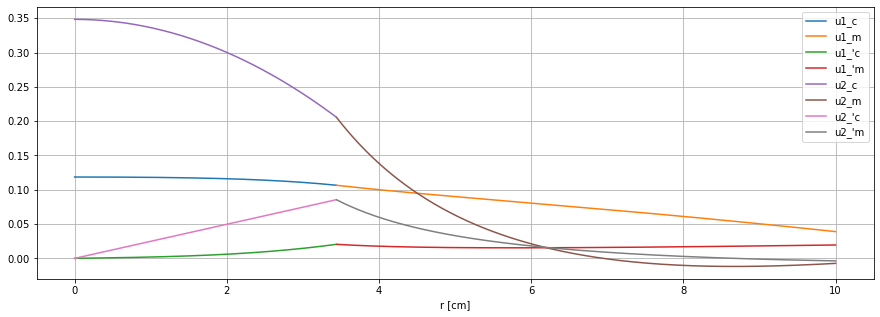

<class 'pandas.core.series.Series'>


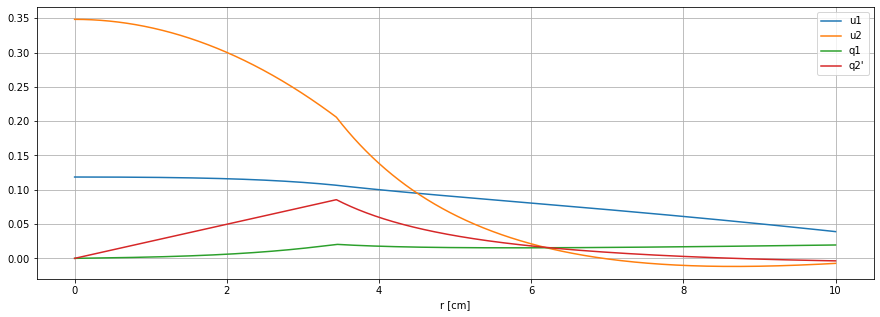

In [18]:
'''Show FEM Solution'''

import pandas as pd
df1 = pd.read_csv('output_omega_1_0002.csv')
df2 = pd.read_csv('output_omega_2_0002.csv')
df_list = [df1,df2]
save_name = "2Domain.png"

#display(df1)
#display(df2)

x_list = [df1["x"],df2["x"]]
y_list = [[df1["diffFlux_u1_c_r"],df1["diffFlux_u2_c_r"],df1["u1_c"],df1["u2_c"]],
          [df2["diffFlux_u1_m_r"],df2["diffFlux_u2_m_r"],df2["u1_m"],df2["u2_m"]]]
labels = ["u1'","u2'","u1","u2"]
domain = ["core","reflector"]


plt.figure(figsize=(15,5))
for i in range(2):
    for j,domain in enumerate(["c","m"]):
        field = "u"+str(i+1)+"_"
        plt.plot(df_list[j]["x"],df_list[j][field+domain],label=field+domain)
        
    for j,domain in enumerate(["c","m"]):
        field = "u"+str(i+1)+"_"
        plt.plot(df_list[j]["x"],df_list[j]["diffFlux_u"+str(i+1)+"_"+domain+"_r"],label=field+"'"+domain)
        
plt.legend()
plt.grid()
plt.xlabel("r [cm]")
plt.show()


x_total = pd.concat([df1["x"], df2["x"]])
u1 = pd.concat([df1["u1_c"] ,df2["u1_m"]])
u2 = pd.concat([df1["u2_c"] , df2["u2_m"]])
u1_prime = pd.concat([df1["diffFlux_u1_c_r"] , df2["diffFlux_u1_m_r"]])
u2_prime = pd.concat([df1["diffFlux_u2_c_r"] , df2["diffFlux_u2_m_r"]])

print(type(df1["u1_c"]))
data_list = [u1,u2,u1_prime,u2_prime]
labels = ["u1","u2","q1","q2'"]

plt.figure(figsize=(15,5))
for i,data in enumerate(data_list):
    plt.plot(x_total,data,label=labels[i])

plt.legend()
plt.grid()
plt.xlabel("r [cm]")
plt.savefig("2Group.png",dpi=300)
plt.show()

k: 0.7221023184034213


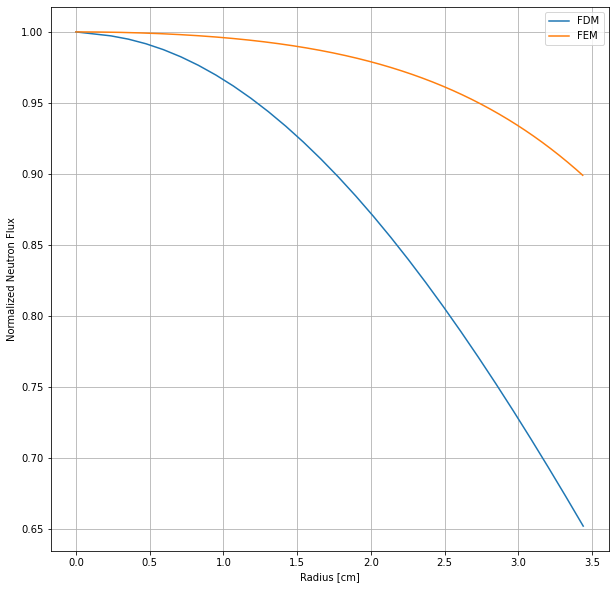

In [19]:
Nr= 30
rn=x_interface 
R=rn
r0=0

D=1.83180150273944
sigma_f=0.07713955230125523
sigma_a=0.003955874476987448
sigma_12=0.03560287029288703
v=3.1
h=(rn-r0)/(Nr-1)
r = np.arange(r0,rn + h,h)
chi=0.575
A=np.zeros((Nr,Nr))
B=np.zeros(Nr)


A[0,0]=-2*D/h**2
A[0,1]=2*D/h**2


for i in range(1,Nr-1):
    A[i,i-1]=(1-(h/r[i]))*D/h**2  
    A[i,i]=-2*D/h**2
    A[i,i+1]=(1+(h/r[i]))*D/h**2


A[-1,-1]=(-2*D/h**2-1/h-1/(rn))
A[-1,-2]=(2)*D/h**2

D, V = LA.eig(A)

eigen_value=D
eigen_vec=V[:,1]
c_star_vec=eigen_vec/LA.norm(eigen_vec[:][0])


eigen_values = np.flip(np.sort(abs(D)))

k=(v*sigma_f)/(min(abs(D))+sigma_a-sigma_12)
print("k:",k)

DD = abs(c_star_vec)
DD /= DD.max()

plt.figure(figsize=(10,10))
plt.plot(r,DD,label="FDM")
plt.plot(df1["x"],df1["u1_c"]/df1["u1_c"].max(),label="FEM")
plt.grid()
plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron Flux")
plt.legend()
plt.show()